# Like A Duck To Water

#### Mistford is a mid-size city located to the southwest of the Boonsong Lekagul Wildlife Prserve. The city has a small industrial area with four light-manufacturing endeavors. Mistford and the wildlife preserve are struggling with the possible endangerment of the rose-crested blue pipit, a locally loved bird. The bird's nesting pairs seem to have decreased alarmingly, prompting an investigation last year implicating a Mistford manufacturing firm. 

#### Since the initial investigation, the situation has evolved: The firm insists that they have done nothing wrong! They assert that grad student Mitch Vogel and his professors are mere media-seekers trying to draw attention away from their lackadaisical research. The firm presents itself as an extremely eco-friendly organization. They have launched their own very public investigation into the issues raised last year and are reporting very different results! It's time to apply your data analytics expertise to help illuminate the path to good science. 

#### The suspect firm was implicated in enviromental damage to the Boonsong Lekagul Wildlife Preserve for both dumping toxic waste and polluting the air with chemicals from its manufacturing process. But they deny any accusation of industrial waste dumping and state that there isn't any ground contamination near any remote ranger station, and they have inspected that area and found it as pristine as the rest of the preserve.

#### Outraged orinthology professors from Mistford College journeyed out to look over the dumping site themselves and perform soil analyses. They returned to report that the site looked like there had been recent excavation and building activities going on. Boonsong Preserve rangers later confirmed that a new ranger station was being built at that stie! Soil samples taken from the site were inconclusive in detecting toxic manufacturing chemicals, as new topsoil had been trucked in. 

#### With a primary piece of evidence now gone, investigators will need to take another approach. Professors in the Mistford College Hydrology Department have come forward with several years of water sensor readings from rivers and streams in the preserve. These samples were taken from different locations scattered throughout the area and contain measurements of several chemicals of possible interest. Could data analytics help reveal something in this data that could amke up for the soil evidence that was destroyed?

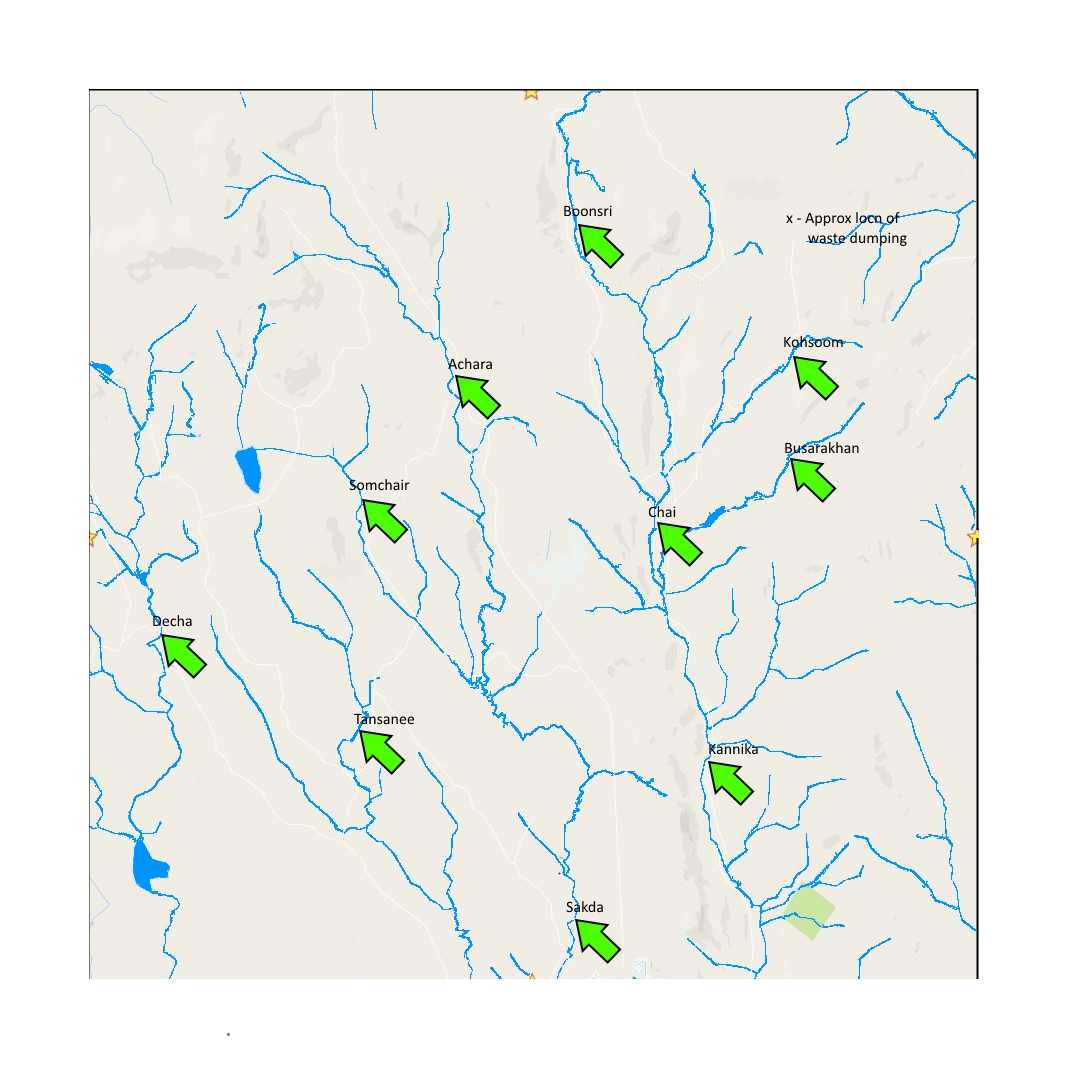

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [2]:
#load in dataset
full_df = pd.read_csv('Boonsong Lekagul waterways readings.csv')

### Goal 1: Characterize the past and most recent situation with respect to chemical contamination in the Boonsong Lekagul waterways. Do you see any trends of possible interest in this investigation?

In [3]:
#we want to get an idea of the shape and feature types
print('shape:', full_df.shape)
print('types:')
print(full_df.dtypes)

shape: (136824, 5)
types:
id               int64
value          float64
location        object
sample date     object
measure         object
dtype: object


In [4]:
#going to change sample to date time and location/measure to categorical
full_df[['location', 'measure']].astype('category')
full_df['sample date'] = pd.to_datetime(full_df['sample date'])
full_df['year'] = full_df['sample date'].dt.year # extract just year data
full_df['month'] = full_df['sample date'].dt.month #extract month
full_df.drop('id', axis = 1, inplace = True) #drop ID as it is only for book keeping
full_df.set_index('sample date', inplace = True) #set date to index

In [5]:
print(full_df.dtypes)
full_df = full_df.sort_values('measure') #sort by measure
full_df.head()

value       float64
location     object
measure      object
year          int64
month         int64
dtype: object


,value,location,measure,year,month
sample date,,,,,
2008-01-24,0.001,Boonsri,"1,2,3-Trichlorobenzene",2008,1
2008-07-25,0.001,Boonsri,"1,2,3-Trichlorobenzene",2008,7
2008-10-26,0.001,Kohsoom,"1,2,3-Trichlorobenzene",2008,10
2009-08-21,0.001,Boonsri,"1,2,3-Trichlorobenzene",2009,8
2008-07-25,0.001,Boonsri,"1,2,3-Trichlorobenzene",2008,7


In [6]:
#see how much each chemical is being measured
chem_counts = full_df['measure'].value_counts()
chem_counts

Water temperature            5031
Nitrites                     4791
Ammonium                     4790
Nitrates                     4786
Orthophosphate-phosphorus    4782
                             ... 
Trifluralin                    12
PCB 118                        12
PCB 28                          8
PCB 52                          8
PAHs                            7
Name: measure, Length: 106, dtype: int64

In [7]:
#view counts for each chemical
unique_measures = full_df['measure'].unique()
print("Number of Chemicals Tested For:",len(unique_measures))

Number of Chemicals Tested For: 106


In [8]:
#filter out chemicals that do not have more than a years (365 days) worth of samples
chem_list = chem_counts[chem_counts > 365].index.tolist()
filtered_df = full_df[full_df['measure'].isin(chem_list)]

In [9]:
#view counts for each chemical after filtering
unique_measures2 = filtered_df['measure'].unique()
print("Number of Chemicals Tested For:",len(unique_measures2))

Number of Chemicals Tested For: 65


In [10]:
#see how much each location is being sampled
filtered_df['location'].value_counts()

Chai          30955
Boonsri       29984
Kannika       21918
Sakda         21242
Kohsoom        7516
Somchair       7426
Busarakhan     7383
Achara         2737
Decha          2702
Tansanee       2119
Name: location, dtype: int64

In [11]:
#check for missing values
filtered_df.isna().sum()

value       0
location    0
measure     0
year        0
month       0
dtype: int64

In [12]:
#look at unique values
def uniqueVals(df):
    for column in df.columns:
        print(column)
        print(df[column].unique())
        print('--------------')
uniqueVals(filtered_df[['location', 'measure', 'year']])

location
['Kannika' 'Boonsri' 'Sakda' 'Kohsoom' 'Busarakhan' 'Somchair' 'Chai'
 'Tansanee' 'Decha' 'Achara']
--------------
measure
['AGOC-3A' 'AOX' 'Alachlor' 'Aldrin' 'Ammonium'
 'Anionic active surfactants' 'Arsenic' 'Atrazine' 'Bicarbonates'
 'Biochemical Oxygen' 'Cadmium' 'Calcium' 'Chemical Oxygen Demand (Cr)'
 'Chemical Oxygen Demand (Mn)' 'Chlorides' 'Chlorodinine' 'Chromium'
 'Copper' 'Cyanides' 'Dieldrin' 'Dissolved oxygen' 'Dissolved silicates'
 'Endosulfan (alpha)' 'Endosulfan (beta)' 'Endrin' 'Fecal coliforms'
 'Fecal streptococci ' 'Heptachlor' 'Heptachloroepoxide' 'Iron' 'Lead'
 'Macrozoobenthos' 'Magnesium' 'Manganese' 'Mercury' 'Methylosmoline'
 'Metolachlor' 'Nickel' 'Nitrates' 'Nitrites' 'Orthophosphate-phosphorus'
 'Oxygen saturation' 'Petroleum hydrocarbons' 'Potassium' 'Silica (SiO2)'
 'Simazine' 'Sodium' 'Sulfides' 'Sulphates' 'Tetrachloromethane'
 'Total coliforms' 'Total dissolved phosphorus' 'Total dissolved salts'
 'Total hardness' 'Total nitrogen' 'Total org

Based on inital data exploration there are no specific trends of interest to investigate. Spikes in chemicals with lower rates of sampling such as PCB 28 may be more easily be considered outliers because we do not have a good measurement over time like we do with other chemicals Nitrites.

We will be interested in chemicals with a high rate of sampling as these will produce the most promising results as to whether or not a measurement may be considered an outlier. 

### Goal 2: What anomalies do you find in the waterway samples dataset? How do these affect your analysis of potential problems to the environment?

In [13]:
#isolating measurements for anomoly detection using LOF
measurements = np.array(filtered_df['value'])
measurements_df = np.reshape(measurements, (-1,1))
lof = LocalOutlierFactor(contamination = 0.1, n_neighbors = 1)
yhat = lof.fit_predict(measurements_df)

In [14]:
lof.get_params()

{'algorithm': 'auto',
 'contamination': 0.1,
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'novelty': False,
 'p': 2}

In [15]:
#see counts of anomolus measurements
anomolus_df = filtered_df.copy()
anomolus_df['outlier prediction'] = yhat
anomolus_df['outlier prediction'].value_counts()

 1    129459
-1      4523
Name: outlier prediction, dtype: int64

In [16]:
outliers = anomolus_df[(anomolus_df['outlier prediction'] == -1)]

In [17]:
print('Number of Chemicals Marked as Having Outliers:', len(outliers['measure'].unique()))
outlier_measures = outliers['measure'].unique()
print('Chemicals Marked as Having Outliers')
print(outlier_measures)

Number of Chemicals Marked as Having Outliers: 48
Chemicals Marked as Having Outliers
['AGOC-3A' 'Alachlor' 'Ammonium' 'Anionic active surfactants' 'Arsenic'
 'Bicarbonates' 'Biochemical Oxygen' 'Cadmium' 'Calcium'
 'Chemical Oxygen Demand (Cr)' 'Chemical Oxygen Demand (Mn)' 'Chlorides'
 'Chromium' 'Copper' 'Cyanides' 'Dissolved oxygen' 'Dissolved silicates'
 'Fecal coliforms' 'Fecal streptococci ' 'Iron' 'Lead' 'Macrozoobenthos'
 'Magnesium' 'Manganese' 'Mercury' 'Methylosmoline' 'Nickel' 'Nitrates'
 'Nitrites' 'Orthophosphate-phosphorus' 'Oxygen saturation'
 'Petroleum hydrocarbons' 'Potassium' 'Silica (SiO2)' 'Sodium' 'Sulphates'
 'Tetrachloromethane' 'Total coliforms' 'Total dissolved phosphorus'
 'Total dissolved salts' 'Total hardness' 'Total nitrogen'
 'Total organic carbon' 'Total phosphorus' 'Water temperature' 'Zinc'
 'p,p-DDD' 'p,p-DDT']


In [18]:
#look at outliers using Isolation Forest
clf = IsolationForest(contamination = 0.1, random_state=0).fit(measurements_df)
preds = clf.predict(measurements_df)
anomolus_df['forest outlier prediction'] = preds
forest_outliers = anomolus_df[(anomolus_df['forest outlier prediction'] == -1)]
print('Number of Chemicals Marked as Having Outliers:', len(forest_outliers['measure'].unique()))
print(forest_outliers['measure'].unique())
print(anomolus_df['forest outlier prediction'].value_counts())

Number of Chemicals Marked as Having Outliers: 27
['AGOC-3A' 'AOX' 'Bicarbonates' 'Biochemical Oxygen' 'Cadmium' 'Calcium'
 'Chemical Oxygen Demand (Cr)' 'Chemical Oxygen Demand (Mn)' 'Chlorides'
 'Chromium' 'Copper' 'Fecal coliforms' 'Fecal streptococci ' 'Iron' 'Lead'
 'Macrozoobenthos' 'Magnesium' 'Manganese' 'Methylosmoline' 'Nickel'
 'Oxygen saturation' 'Sodium' 'Sulphates' 'Total coliforms'
 'Total dissolved salts' 'Total hardness' 'Zinc']
 1    120618
-1     13364
Name: forest outlier prediction, dtype: int64


In [19]:
#see what chemicals were marked as outliers in both models
similar_outliers = anomolus_df[(anomolus_df['outlier prediction'] == -1) & (anomolus_df['forest outlier prediction'] == -1)]
print('Number of Chemicals Marked as Having Outliers:', len(similar_outliers['measure'].unique()))
similar_outlier_measures = similar_outliers['measure'].unique()
print('Similar Chemicals Marked as Having Outliers:')
print(similar_outlier_measures)

Number of Chemicals Marked as Having Outliers: 21
Similar Chemicals Marked as Having Outliers:
['AGOC-3A' 'Bicarbonates' 'Biochemical Oxygen' 'Cadmium' 'Calcium'
 'Chemical Oxygen Demand (Cr)' 'Chlorides' 'Chromium' 'Copper' 'Iron'
 'Lead' 'Magnesium' 'Manganese' 'Methylosmoline' 'Oxygen saturation'
 'Sodium' 'Sulphates' 'Total coliforms' 'Total dissolved salts'
 'Total hardness' 'Zinc']


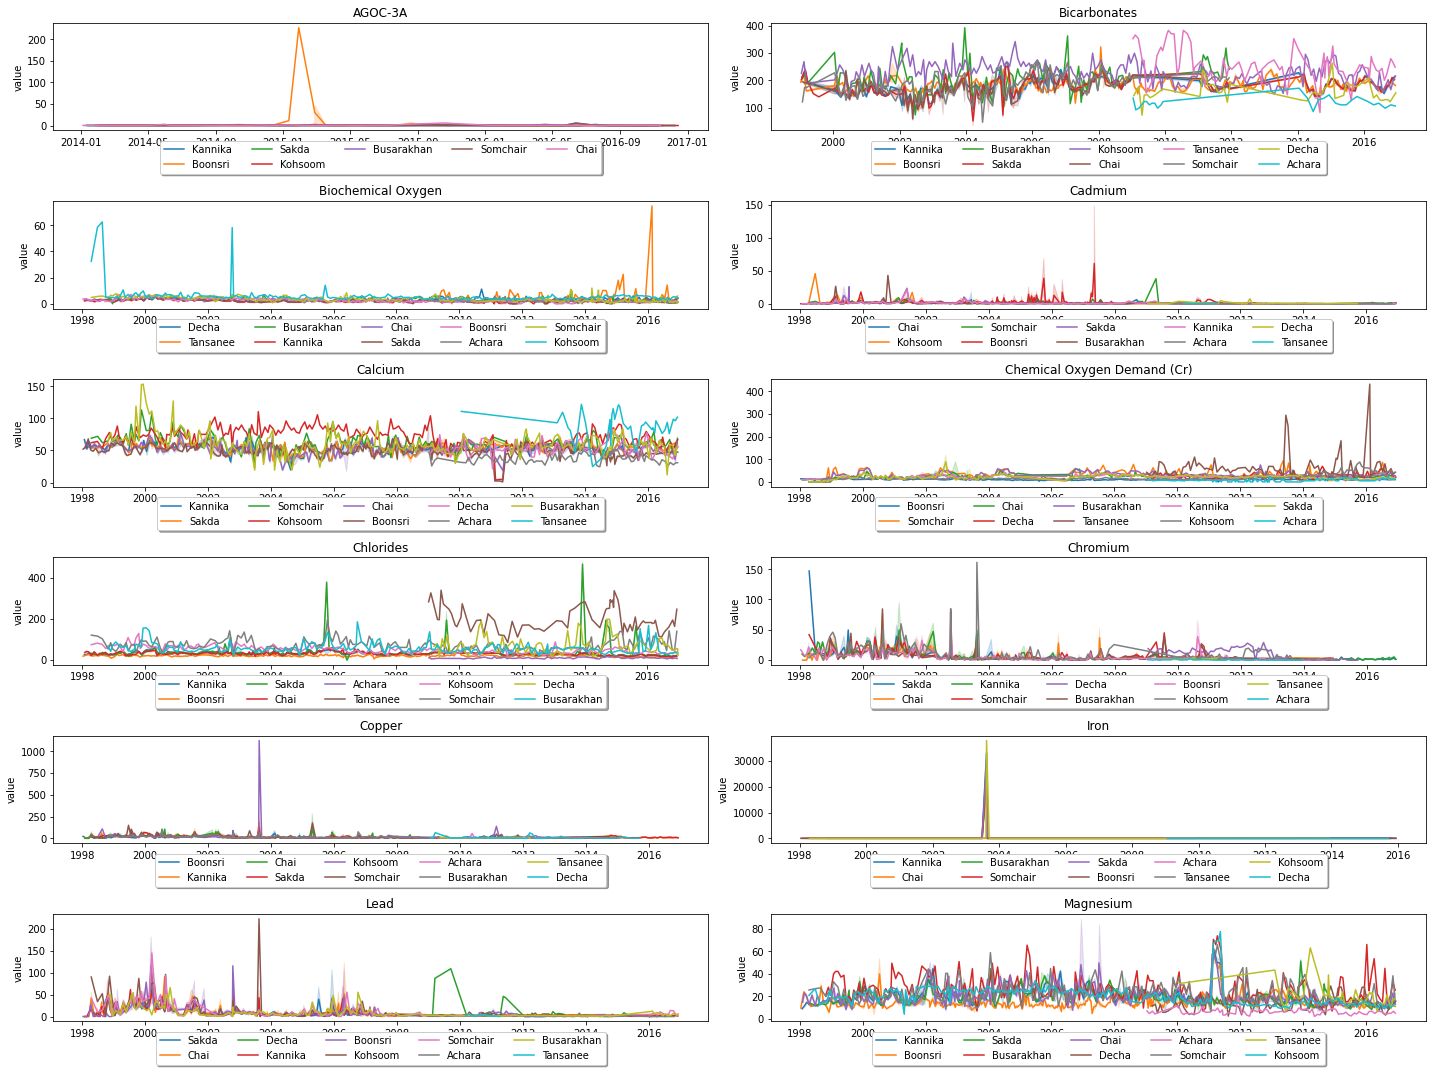

In [20]:
#look at first 12 chemicals marked as outliers
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 15))

for chemical, ax in zip(similar_outlier_measures[:12], axs.ravel()):
    sns.lineplot(data = filtered_df[(filtered_df['measure'] == chemical)].reset_index(), ax = ax, x = 'sample date',y = 'value',
                   hue = 'location').set(title = chemical, xlabel = " ")
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    
plt.tight_layout()
plt.show()

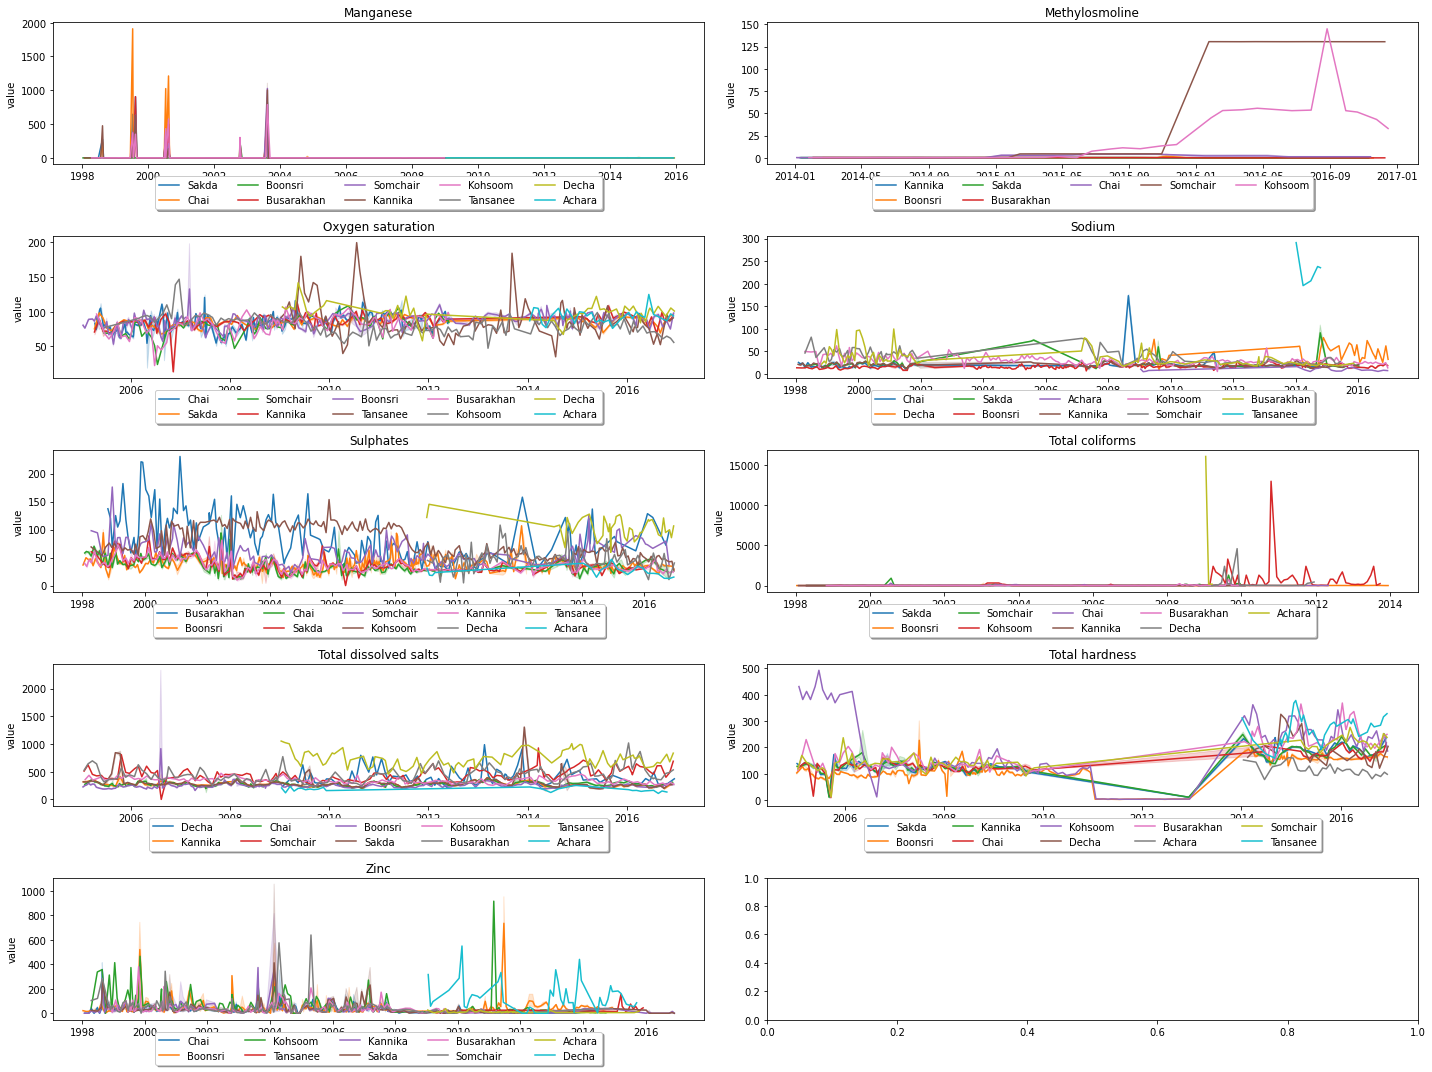

In [21]:
#look at last 13 chemicals marked as outliers
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))

for chemical, ax in zip(similar_outlier_measures[12:], axs.ravel()):
    sns.lineplot(data = full_df[(full_df['measure'] == chemical)].reset_index(), ax = ax, x = 'sample date',y = 'value',
                   hue = 'location').set(title = chemical, xlabel = " ")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show()

In [22]:
#look at anomalous findings in the last year
anomaly=anomolus_df.loc[(anomolus_df['outlier prediction']==-1) & (anomolus_df['forest outlier prediction'] == -1)]
anomaly_index=list(anomaly.index)
data2016 = anomaly[anomaly['year'] == 2016]
unique_chems = data2016['measure'].unique()
print(unique_chems)
print(data2016.shape)

['Bicarbonates' 'Biochemical Oxygen' 'Calcium'
 'Chemical Oxygen Demand (Cr)' 'Chlorides' 'Methylosmoline'
 'Oxygen saturation' 'Sulphates' 'Total dissolved salts' 'Total hardness']
(196, 7)


In [23]:
data2016.head()

,value,location,measure,year,month,outlier prediction,forest outlier prediction
sample date,,,,,,,
2016-02-20,205.570,Kohsoom,Bicarbonates,2016,2,-1,-1
2016-08-07,153.110,Kannika,Bicarbonates,2016,8,-1,-1
2016-02-17,243.850,Tansanee,Bicarbonates,2016,2,-1,-1
2016-02-11,218.380,Sakda,Bicarbonates,2016,2,-1,-1
2016-10-21,165.188,Kohsoom,Bicarbonates,2016,10,-1,-1


In [24]:
for chemical in unique_chems:
    print('***',chemical, '***')
    data = data2016[data2016['measure'] == chemical]
    print(data.sort_values('location'))
    print('--------------')

*** Bicarbonates ***
               value  location       measure  year  month  outlier prediction  \
sample date                                                                     
2016-04-15   134.900     Decha  Bicarbonates  2016      4                  -1   
2016-07-17   125.700     Decha  Bicarbonates  2016      7                  -1   
2016-12-16   153.800     Decha  Bicarbonates  2016     12                  -1   
2016-11-11   208.160   Kannika  Bicarbonates  2016     11                  -1   
2016-08-07   153.110   Kannika  Bicarbonates  2016      8                  -1   
2016-02-20   205.570   Kohsoom  Bicarbonates  2016      2                  -1   
2016-10-21   165.188   Kohsoom  Bicarbonates  2016     10                  -1   
2016-11-18   199.650   Kohsoom  Bicarbonates  2016     11                  -1   
2016-06-19   228.570   Kohsoom  Bicarbonates  2016      6                  -1   
2016-05-28   168.116   Kohsoom  Bicarbonates  2016      5                  -1   
2016-04

In [25]:
dataOct2016 = data2016[data2016['month'] == 10]
dataOct2016.shape

(16, 7)

In [26]:
unique_chems2 = dataOct2016['measure'].unique()
print(unique_chems2)

['Bicarbonates' 'Calcium' 'Chlorides' 'Oxygen saturation'
 'Total dissolved salts' 'Total hardness']


In [27]:
for chemical in unique_chems2:
    print('***',chemical, '***')
    data = dataOct2016[dataOct2016['measure'] == chemical]
    print(data.sort_values('location'))
    print('--------------')

*** Bicarbonates ***
               value  location       measure  year  month  outlier prediction  \
sample date                                                                     
2016-10-21   165.188   Kohsoom  Bicarbonates  2016     10                  -1   
2016-10-21   278.890  Tansanee  Bicarbonates  2016     10                  -1   

             forest outlier prediction  
sample date                             
2016-10-21                          -1  
2016-10-21                          -1  
--------------
*** Calcium ***
              value  location  measure  year  month  outlier prediction  \
sample date                                                               
2016-10-21   98.597  Tansanee  Calcium  2016     10                  -1   

             forest outlier prediction  
sample date                             
2016-10-21                          -1  
--------------
*** Chlorides ***
             value  location    measure  year  month  outlier prediction  \
s

Using two models there were a total of 23 chemicals that overlapped with having instances marked as outliers. The original chemcial of interest (Methylosmoline) shows a spike in 2016 in two locations. We can also see that not all of the locations were sampled for specific chemicals. For example Total Coliforms was not sampled in Tansanee. This can cause interpretation issues as to whether or not something could be considered an outlier, or if we just do not have enough information to indicate that it is of normal measurement.

### Goal 3: Is the Hydrology Department collecting sufficient data to understand the comprehensive situation across the preserve? What changes would you propose to make in the sampling approach to best understand the situation?

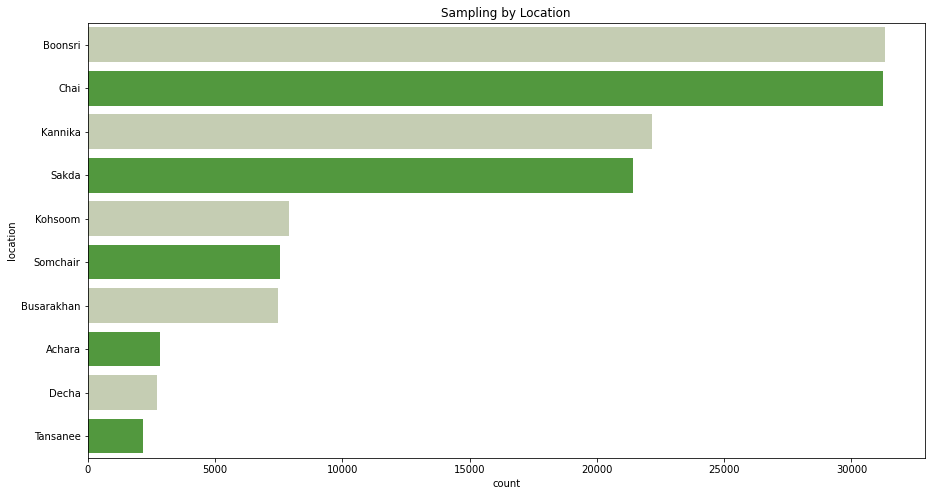

In [28]:
#visualize sampling by location
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot(data = full_df, y = 'location', palette=['#c7d1af',"#4aa72f"], 
              order = full_df['location'].value_counts().index).set(title = 'Sampling by Location')
plt.show()

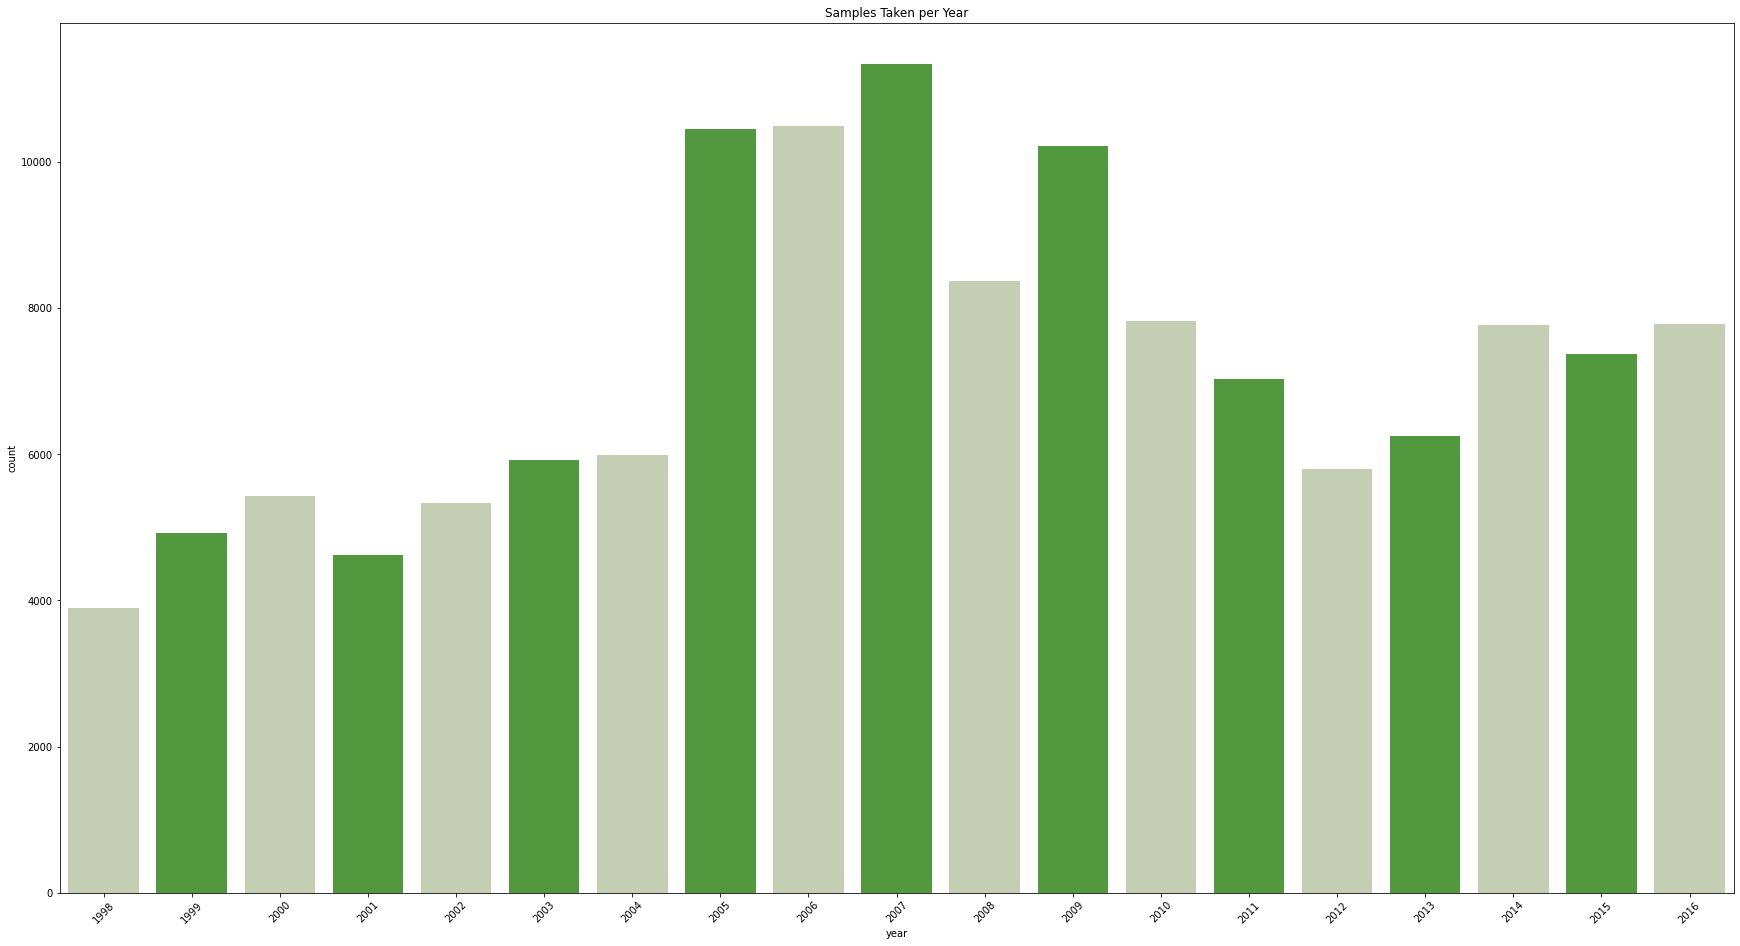

In [29]:
#plot number of samples taken each year
fig6, ax = plt.subplots(figsize = (30,16))
sns.countplot(data = full_df, x = 'year', palette=['#c7d1af',"#4aa72f"]).set(title = 'Samples Taken per Year')
plt.xticks(rotation=45)
plt.show()

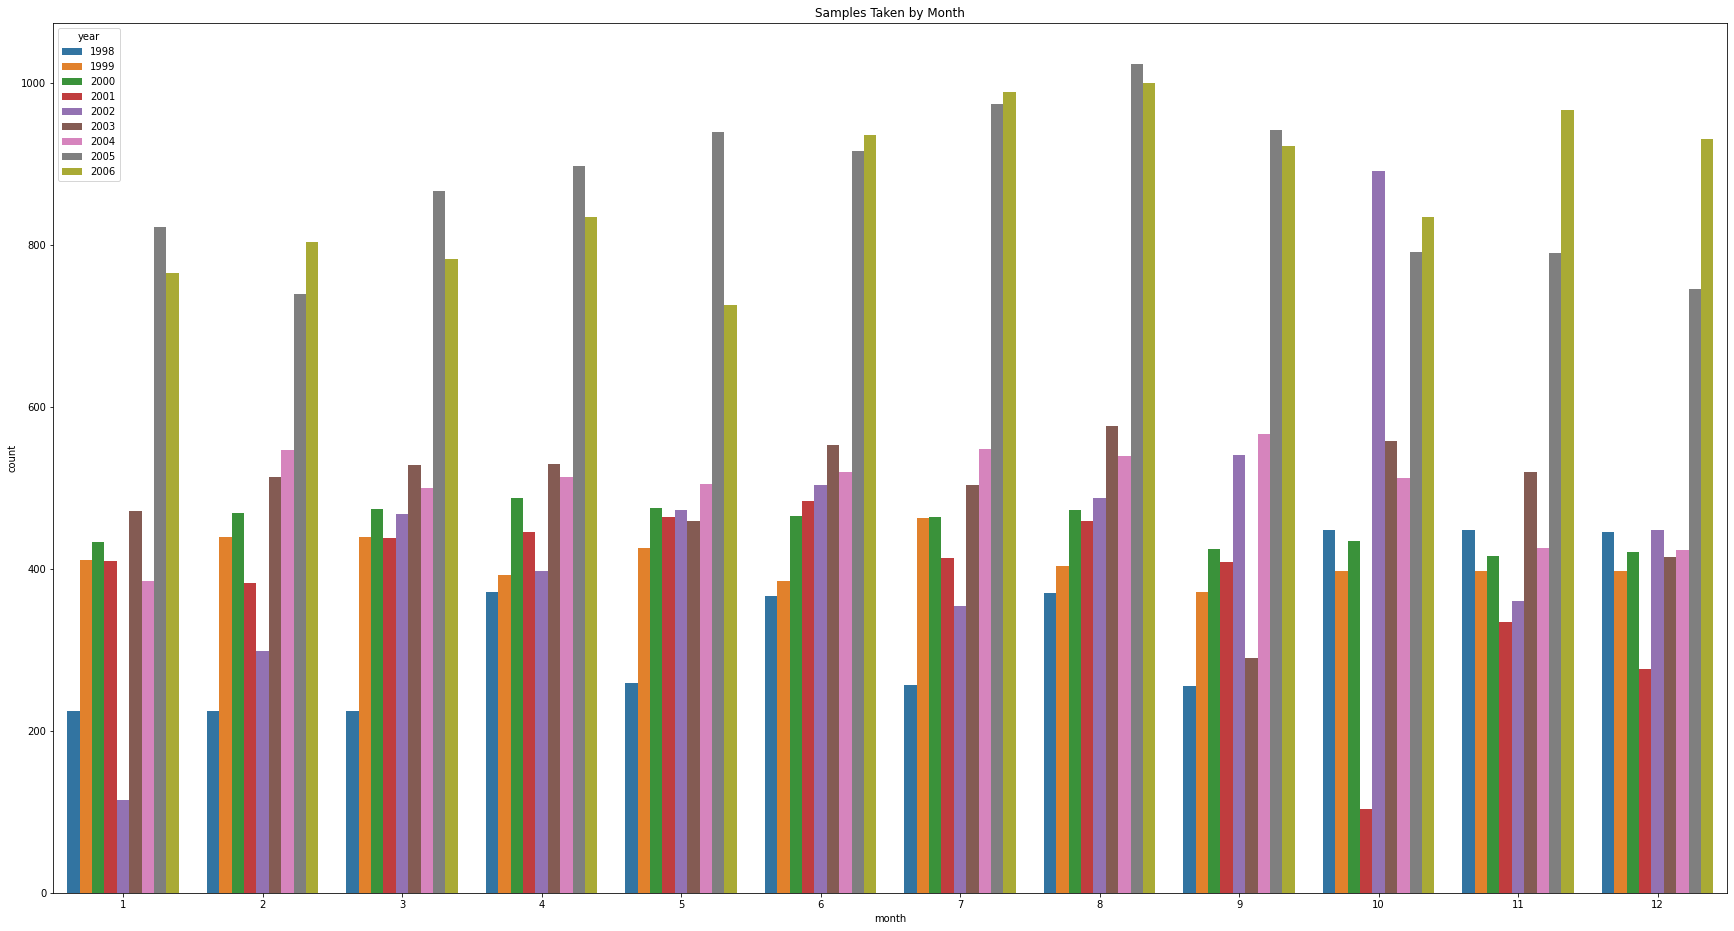

In [30]:
#plot number of samples taken by month
fig, ax = plt.subplots(figsize= (30,16))
first10 = full_df[full_df['year'] < 2007]
last10 = full_df[full_df['year'] >= 2007]
sns.countplot(data = first10, x = 'month', hue = 'year').set(title = 'Samples Taken by Month')
plt.show()

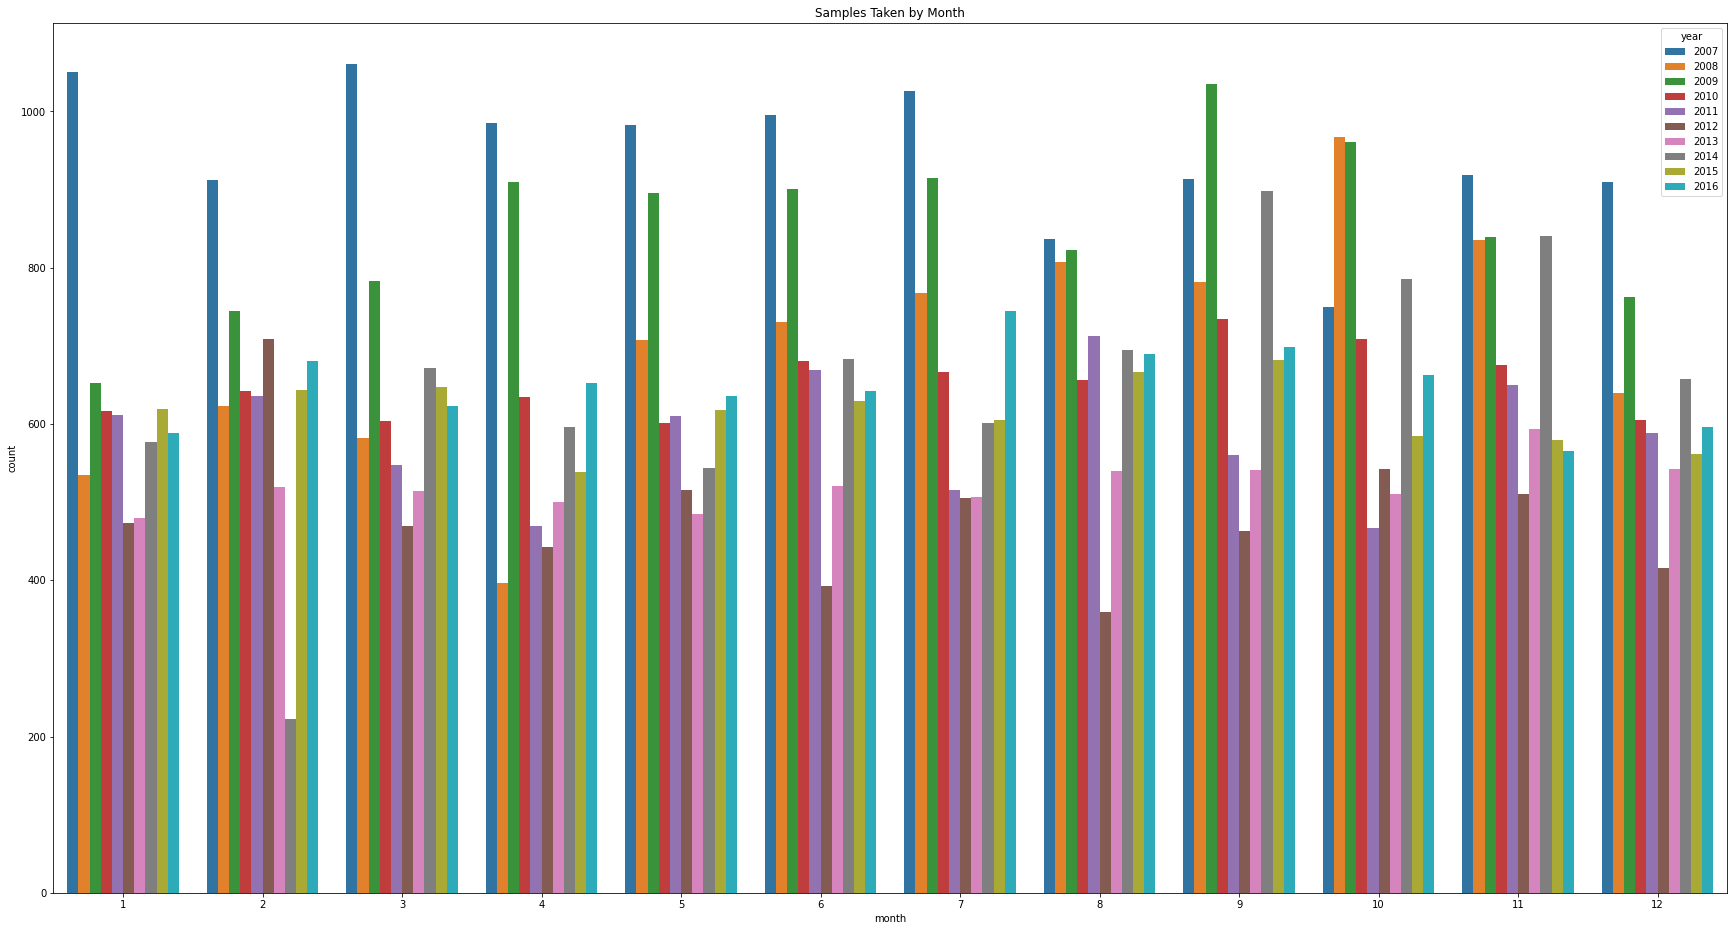

In [31]:
fig, ax = plt.subplots(figsize= (30,16))
first10 = full_df[full_df['year'] < 2007]
last10 = full_df[full_df['year'] >= 2007]
sns.countplot(data = last10, x = 'month', hue = 'year').set(title = 'Samples Taken by Month')
plt.show()

In [32]:
#average number of samples taken
avg = len(full_df)/len(full_df['measure'].unique())
print("average number of samples", avg)

average number of samples 1290.7924528301887


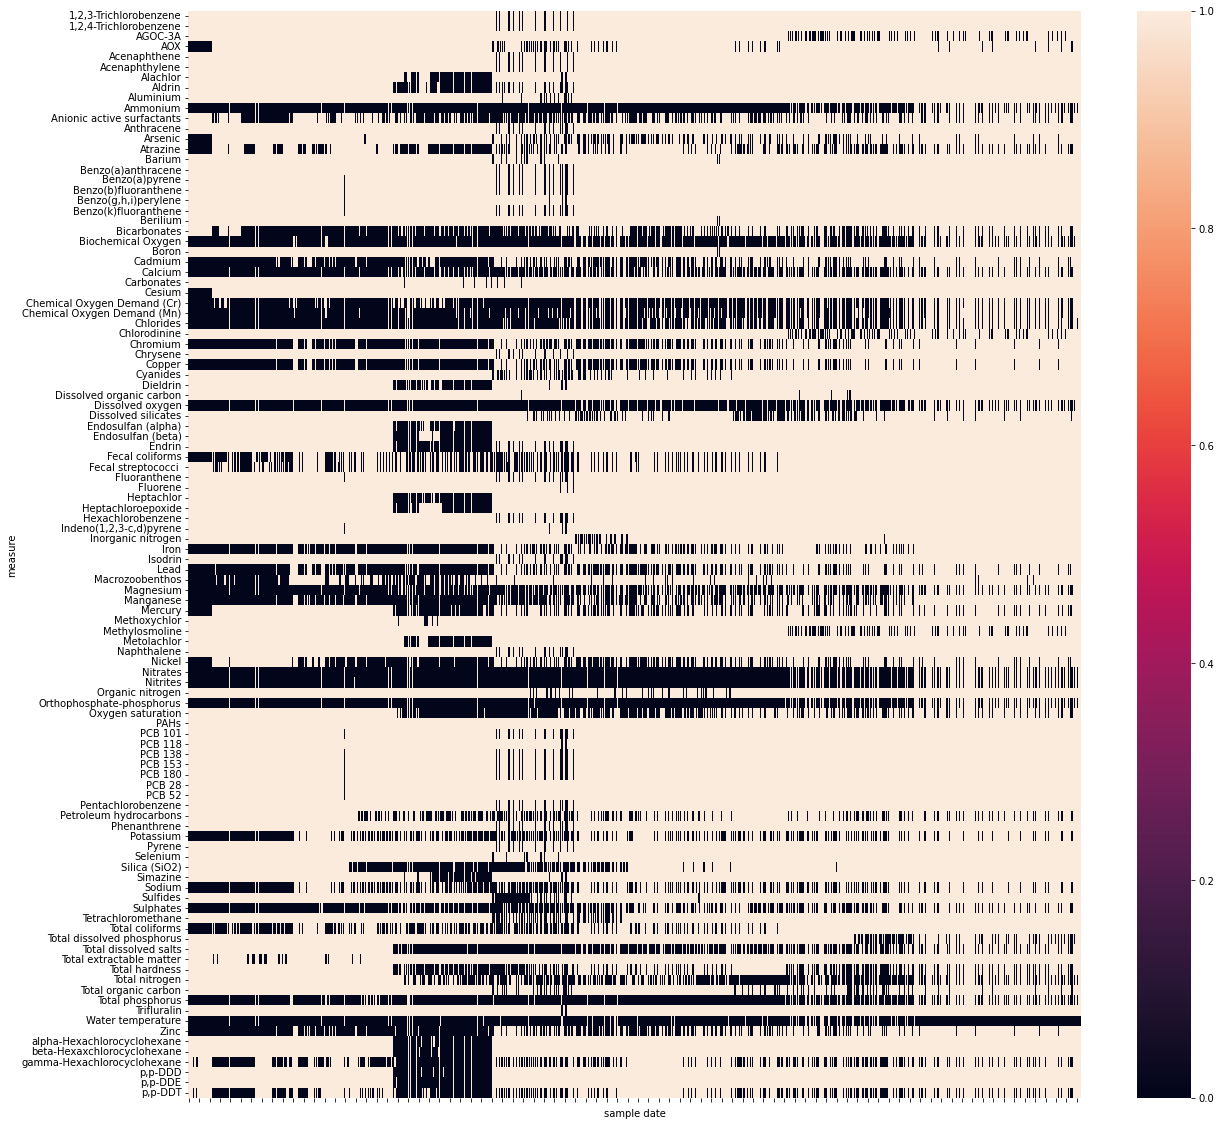

In [33]:
measure_group = full_df.groupby(['sample date', 'measure'], group_keys=False).count().squeeze().unstack()
fig, ax = plt.subplots(figsize= (20,20))
sns.heatmap(measure_group['value'].isna().transpose())
ax.set(xticklabels=[])
plt.show()

In [34]:
#look at measurements taken for each chemical on each date
#measurements_by_year_df = full_df.groupby(['sample date','location','year', 'month','measure']).count().squeeze().unstack().add_suffix('_count').sort_index()
print('Shape:', measure_group['value'].shape)
print('Sum of Missing Data:', measure_group['value'].isna().sum().sum())

Shape: (1965, 106)
Sum of Missing Data: 160980


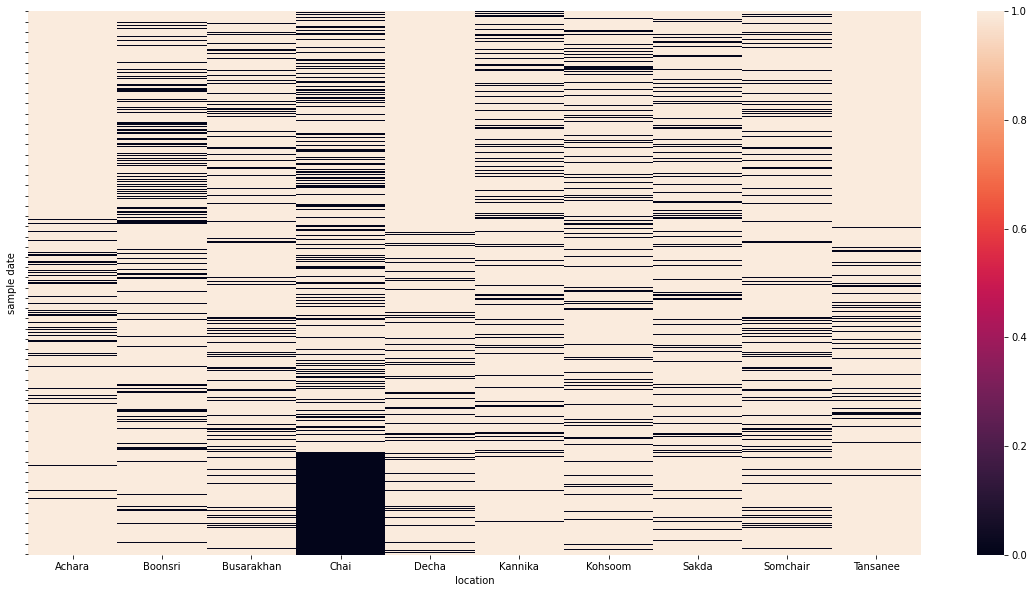

In [35]:
location_group = full_df.groupby(['sample date', 'location'], group_keys=False).count().squeeze().unstack()
fig, ax = plt.subplots(figsize= (20,10))
sns.heatmap(location_group['value'].isna())
ax.set(yticklabels=[])
plt.show()

In [36]:
#look at measurements taken for each location on each date
print('Shape:', location_group['value'].shape)
print('Sum of Missing Data:', location_group['value'].isna().sum().sum())

Shape: (1965, 10)
Sum of Missing Data: 16586


Althought the data presented is good, I do believe that the inconsistencies in sampling procedure for each location over time does bias the results in determining anomolies. 

### Goal 4: After reviewing the data, do any of your findings cause particular concern for the pipit or other wildlife? Would you suggest any changes in the sampling strategy to better understand the waterways situation in the preserve?

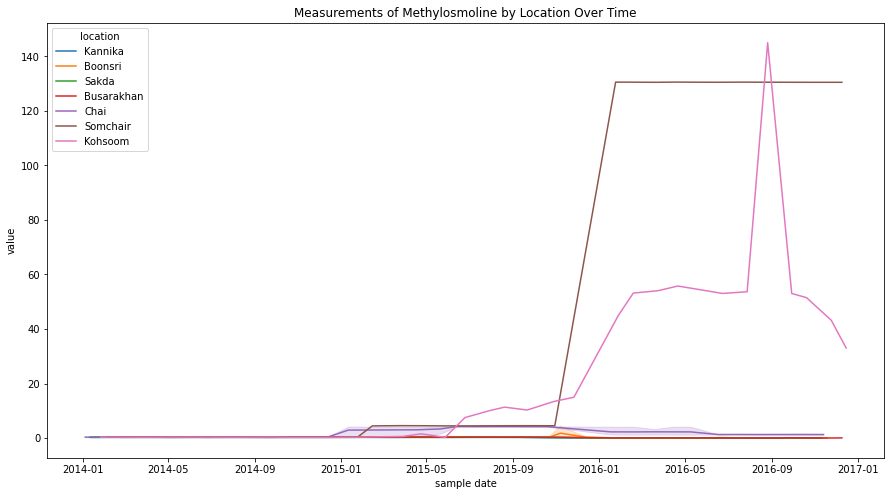

In [37]:
#Isolate the original chemical of interest to see trends over time of measurements
fig1, ax = plt.subplots(figsize = (15,8))
sns.lineplot(data = full_df[full_df['measure'] == 'Methylosmoline'].reset_index(), 
             x = 'sample date', y = 'value', 
             hue = 'location').set(title = 'Measurements of Methylosmoline by Location Over Time')
plt.show()

It appears that in January of 2016 there was a spike in Methylosmoline levels in Somchair. There also appears to be a gradual increase in Methylosmoline levels in Kohsoom beginning shortly after May 2015 and eventually spiking around September 2016. 

Based on the map provided Kohsoom is near the approximate location of the alleged waste dumping. These increased levels could be a result of dumping by Kasios. 

There isn't an apparent reason for the spike in Somchair as it is farther away from the alleged dumping ground. 

This spike near Kohsoom could be cause for concern for the wildlife in the preserve; however, I believe that the inconsistencies in measurement could be reason for pause in really determining outliers. 